In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

2024-05-10 05:59:17.932438: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25363087360


# Sign Prediction Tests - Hickok & Blumberg
> Comparisons between Diffusion Curvature and the Competition

**Hypothesis**: Stuff will happen

# Machinery

We'll perform the saddle-sphere ablations in several dimensions, then merge the metrics into a single table.

In [2]:
from diffusion_curvature.benchmarking.hickok import scalar_curvature_est 

In [3]:
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

In [4]:
SS1 = SadSpheres(
    dimension = dims, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)']


In [5]:
SS1.load_from_disk()

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)']


In [6]:
dim = dims[0]

# graph_former = partial(get_curvature_agnostic_graph, k = dim*2, )
# graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)
for X in tqdm(SS1):
    # G = graph_former(X)
    # DC = DiffusionCurvature(
    #     laziness_method="Wasserstein",
    #     flattening_method="Fixed",
    #     comparison_method="Ollivier",
    #     graph_former = graph_former,
    #     points_per_cluster=None,  # construct separate comparison spaces around each point
    #     comparison_space_size_factor=1,
    # )
    # ks = DC.curvature(G, dim = X.shape[1], t = 25)
    # SS1.update(ks[0], method_name="Diffusion Curvature (Entropic)")

    # DC = DiffusionCurvature(
    #     laziness_method="Entropic",
    #     flattening_method="Fixed",
    #     comparison_method="Subtraction",
    #     graph_former = graph_former,
    #     points_per_cluster=None,  # construct separate comparison spaces around each point
    #     comparison_space_size_factor=1,
    # )
    # ks = DC.curvature(G, dim = X.shape[1], t = 25)
    # SS1.update(ks[0], method_name="Diffusion Curvature (Wasserstein)")
    
    SC = scalar_curvature_est(
        n = dim, #manifold dim
        X = X, #data
        verbose=False,
    )
    ks_est = SC.estimate(rmax=3.14, indices=[0], )
    SS1.update(ks_est[0], method_name="Hickok & Blumberg")

  0%|          | 0/300 [00:00<?, ?it/s]

In [7]:
SS1.DS[0].results

{'ks': {'ground truth': -8.0,
  'Diffusion Curvature (Entropic)': Array(-0.20707679, dtype=float32),
  'Diffusion Curvature (Wasserstein)': Array(-0.00519323, dtype=float32),
  'Hickok & Blumberg': -3.027323619927813}}

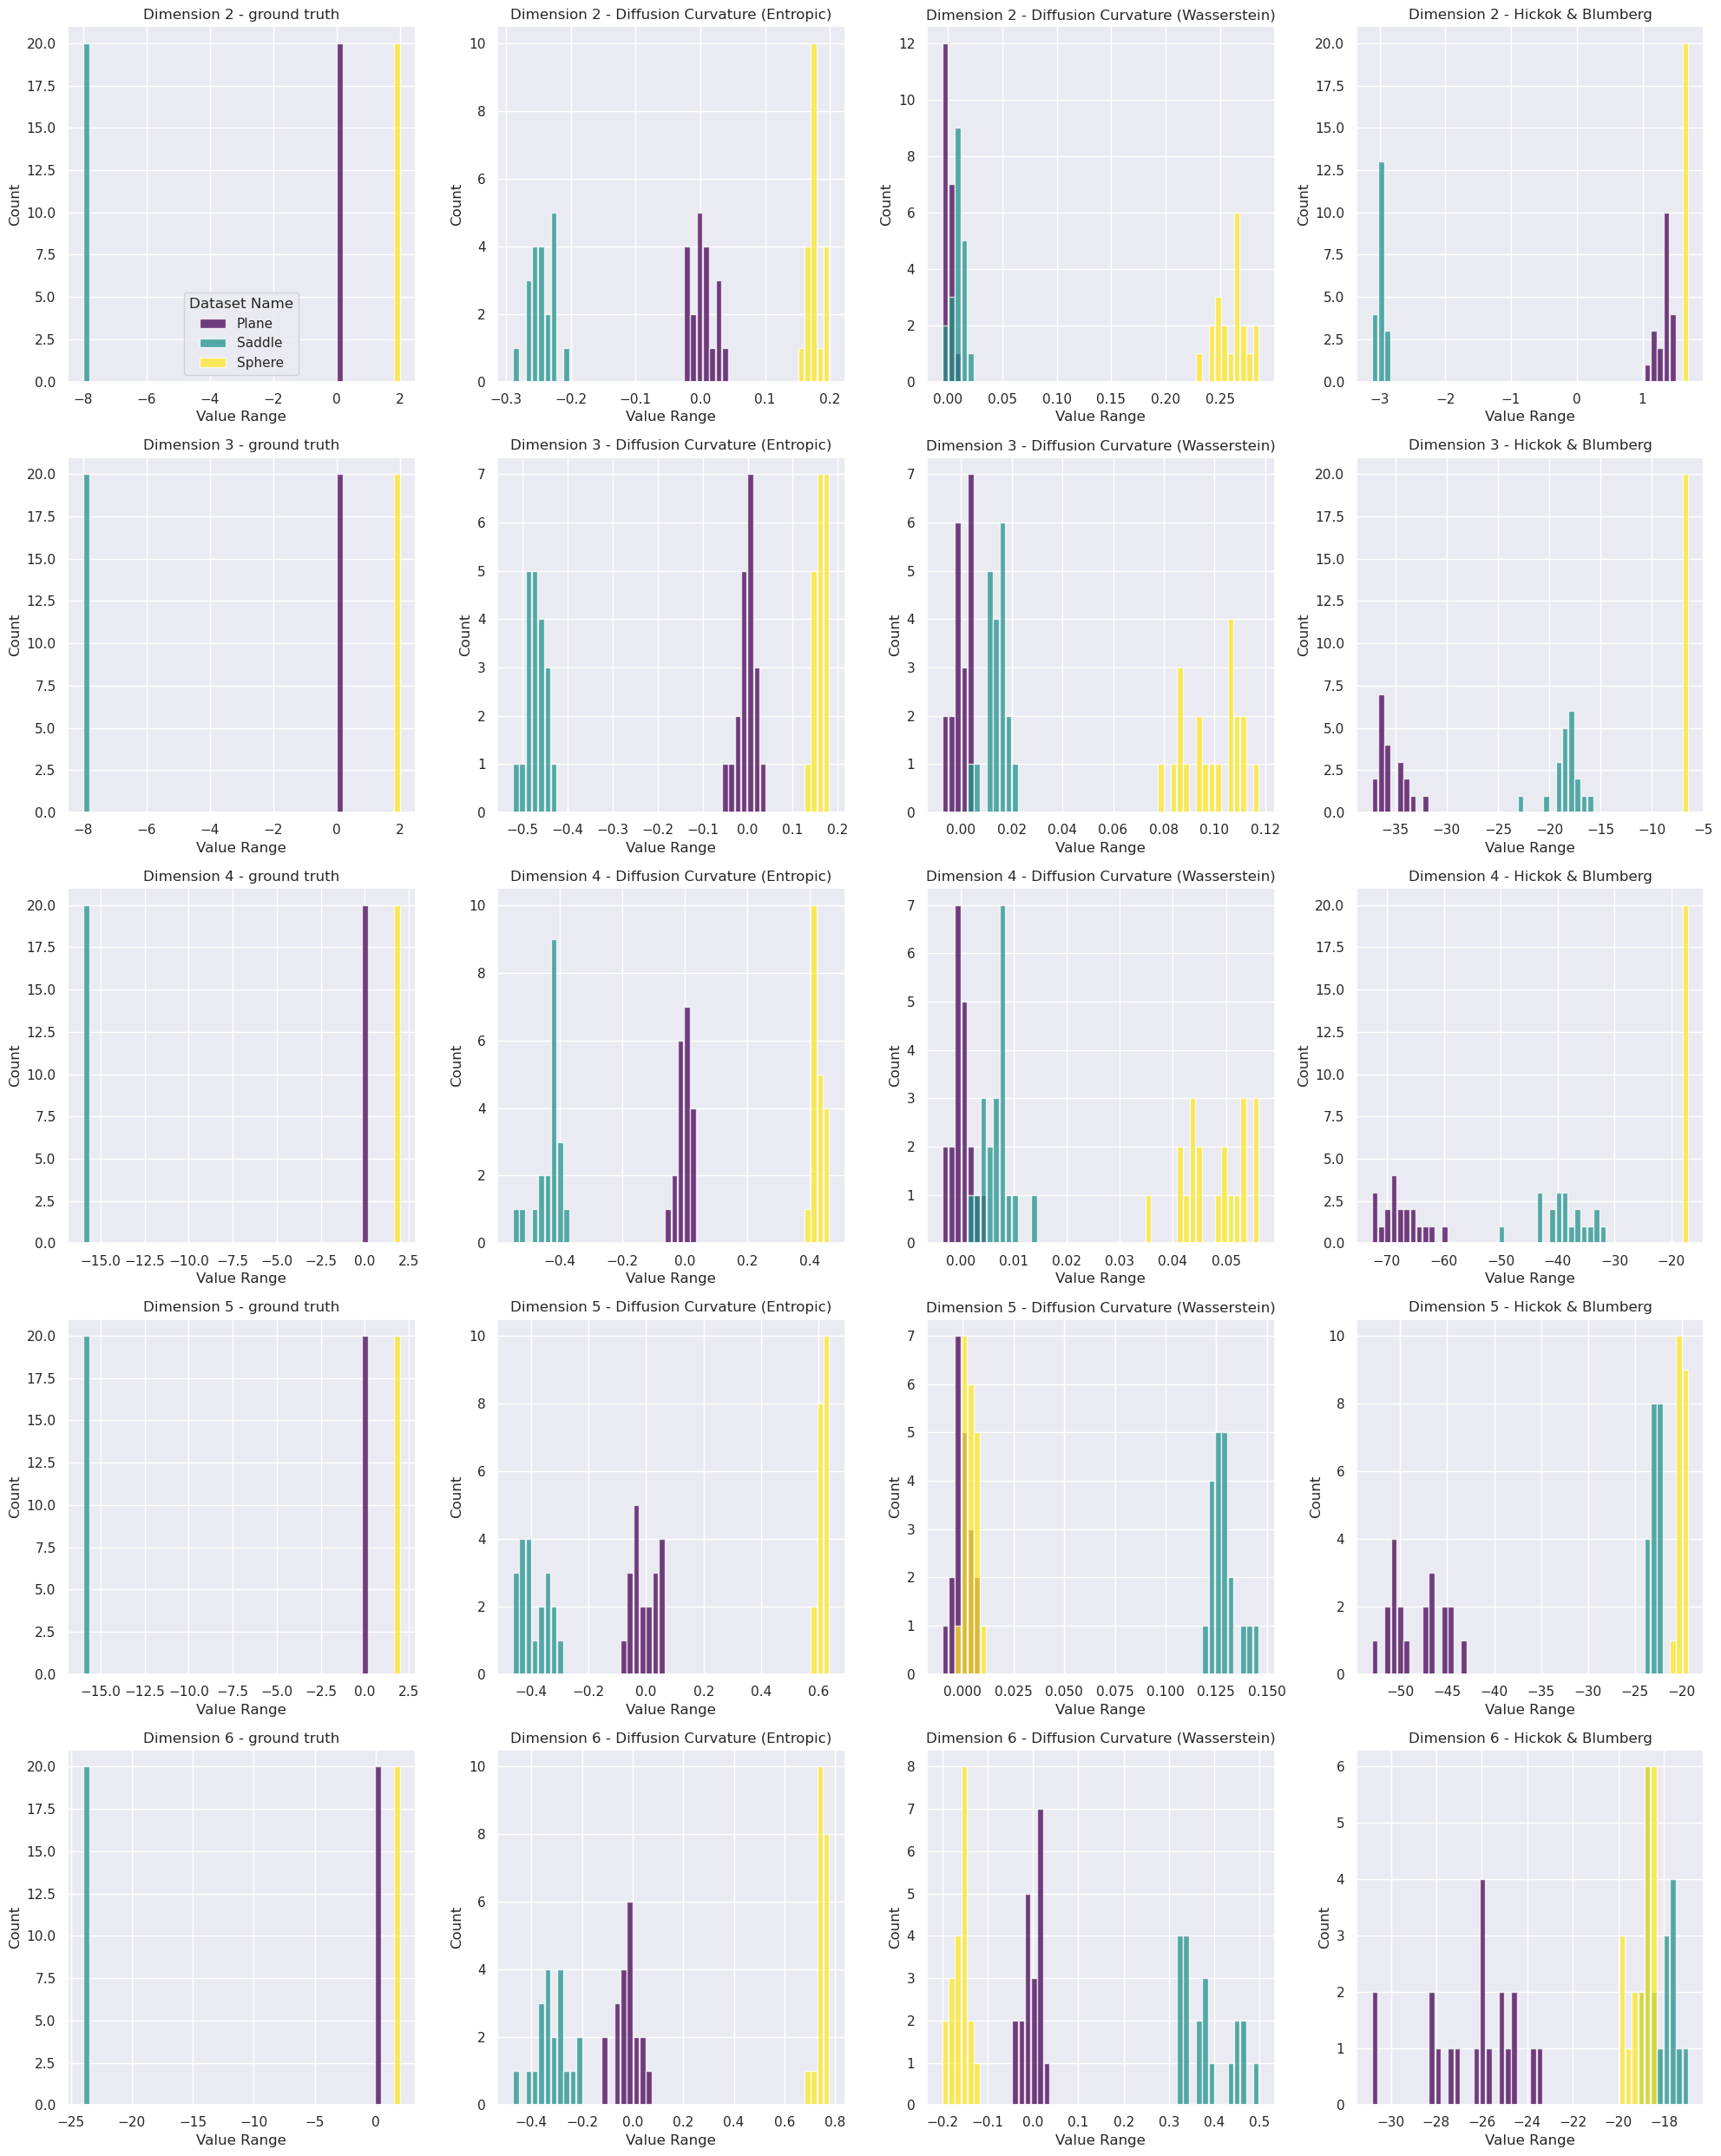

In [8]:
SS1._aggregate_labels()
SS1.plot_by_dimension()

In [16]:
dim = dims[1]
SS2 = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=False,
)
graph_former = partial(fixed_graph_former, alpha=1, sigma=0.2)
for X in tqdm(SS2):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
    )
    ks = DC.curvature(G, dim = dim, t = 25)
    SS2.update(ks[0], method_name="Diffusion Curvature")
    
    SC = scalar_curvature_est(
        n = dim, #manifold dim
        X = X, #data
        verbose=False,
    )
    ks_est = SC.estimate(rmax=2, indices=[0])
    SS2.update(ks_est[0], method_name="Hickok")
SS2.table()
SS_across_dims.append(SS2)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
dim = dims[2]
SS3 = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=False,
)
graph_former = partial(fixed_graph_former, alpha=1, sigma=0.2)
for X in tqdm(SS3):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
    )
    ks = DC.curvature(G, dim = dim, t = 25)
    SS3.update(ks[0], method_name="Diffusion Curvature")
    
    SC = scalar_curvature_est(
        n = dim, #manifold dim
        X = X, #data
        verbose=False,
    )
    ks_est = SC.estimate(rmax=2, indices=[0])
    SS3.update(ks_est[0], method_name="Hickok")
SS3.table()
SS_across_dims.append(SS3)

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
SS1.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",0.693147
Diffusion Curvature,"(0.9984105720715597, 6.112610445808439e-24)",0.693147
Hickok,"(0.998019278582181, 4.4244318564697817e-23)",0.000000


In [18]:
SS2.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",0.693147
Diffusion Curvature,"(0.996714712386192, 4.183748916786387e-21)",0.693147
Hickok,"(0.9821843344795909, 1.609923177144267e-14)",0.000000


In [19]:
SS3.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",0.693147
Diffusion Curvature,"(0.9974141408831724, 4.863441066514706e-22)",0.693147
Hickok,"(0.719893584221904, 0.0003451575770241438)",0.000000


In [25]:
SS_across_dims[-3].plot()

IndexError: list index out of range

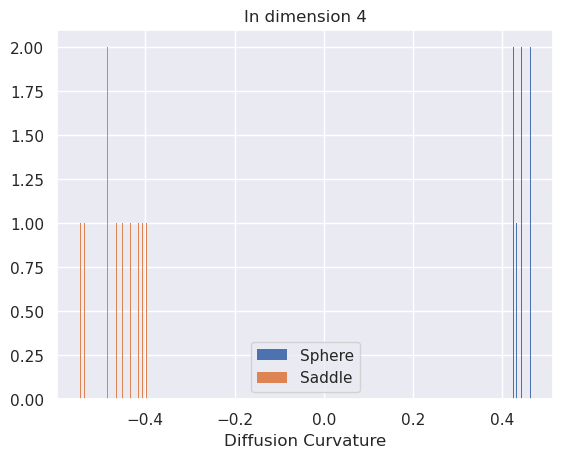

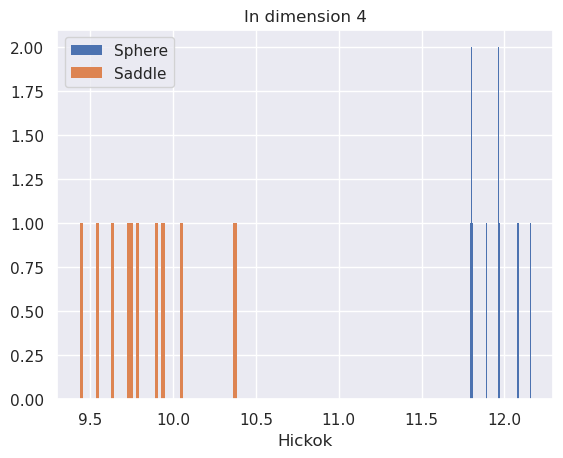

In [26]:
SS2.plot()

In [24]:
SS_across_dims[-3].plot()

IndexError: list index out of range

In [53]:
len(SS)

20

# Results

We want to merge the dataframes of each dimension, and display them as a unified table.

In [20]:
SSs = [SS1, SS2, SS3]

In [21]:
import pandas as pd
dfs = [SS.table() for SS in SSs]
df = pd.concat(dfs)
# show nicely styled table
df.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background', '#606060'),
                ('color', 'white'),
                ('font-family', 'verdana')]},
     {'selector': 'td',
      'props': [('font-family', 'verdana')]},
     {'selector': 'tr:nth-of-type(odd)',
      'props': [('background', '#f9f9f9')]},
     {'selector': 'tr:nth-of-type(even)',
      'props': [('background', 'white')]},
     {'selector': 'tr:hover',
      'props': [('background-color', '#f4f4f4')]}
    ]
)


,pearson_r,sign_score
ks,"PearsonRResult(statistic=1.0, pvalue=0.0)",0.693147
Diffusion Curvature,"PearsonRResult(statistic=0.9984105720715597, pvalue=6.112610445808439e-24)",0.693147
Hickok,"PearsonRResult(statistic=0.998019278582181, pvalue=4.4244318564697817e-23)",0.000000
ks,"PearsonRResult(statistic=1.0, pvalue=0.0)",0.693147
Diffusion Curvature,"PearsonRResult(statistic=0.996714712386192, pvalue=4.183748916786387e-21)",0.693147
Hickok,"PearsonRResult(statistic=0.9821843344795909, pvalue=1.609923177144267e-14)",0.000000
ks,"PearsonRResult(statistic=1.0, pvalue=0.0)",0.693147
Diffusion Curvature,"PearsonRResult(statistic=0.9974141408831724, pvalue=4.863441066514706e-22)",0.693147
Hickok,"PearsonRResult(statistic=0.719893584221904, pvalue=0.0003451575770241438)",0.000000


In [22]:
# plot a table of the above with rows and columns flipped
df.T.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background', '#606060'),
                ('color', 'white'),
                ('font-family', 'verdana')]},
     {'selector': 'td',
      'props': [('font-family', 'verdana')]},
     {'selector': 'tr:nth-of-type(odd)',
      'props': [('background', '#f9f9f9')]},
     {'selector': 'tr:nth-of-type(even)',
      'props': [('background', 'white')]},
     {'selector': 'tr:hover',
      'props': [('background-color', '#f4f4f4')]}
    ]
)

,ks,Diffusion Curvature,Hickok,ks,Diffusion Curvature,Hickok,ks,Diffusion Curvature,Hickok
pearson_r,"PearsonRResult(statistic=1.0, pvalue=0.0)","PearsonRResult(statistic=0.9984105720715597, pvalue=6.112610445808439e-24)","PearsonRResult(statistic=0.998019278582181, pvalue=4.4244318564697817e-23)","PearsonRResult(statistic=1.0, pvalue=0.0)","PearsonRResult(statistic=0.996714712386192, pvalue=4.183748916786387e-21)","PearsonRResult(statistic=0.9821843344795909, pvalue=1.609923177144267e-14)","PearsonRResult(statistic=1.0, pvalue=0.0)","PearsonRResult(statistic=0.9974141408831724, pvalue=4.863441066514706e-22)","PearsonRResult(statistic=0.719893584221904, pvalue=0.0003451575770241438)"
sign_score,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000


# Conclusion